# **Tutorial 2 SpatialEx+ Enables Larger Panel Spatial Analysis through Panel Diagonal Integration**

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import SpatialEx as se

device = 'cuda:9'

## 1. Prepare the dataset

### Choice 1: [Download](https://www.10xgenomics.com/products/xenium-in-situ/human-breast-dataset-explorer) the Xenium Human Breast Cancer tissue dataset.

We provide H&E image representations generated by different image large models, and the preprocessed data can be downloaded via the following link:

**UNI (Default)**: [Slice 1](https://drive.google.com/file/d/1W2QBrb0AQH0f0I7sS8vsdhZmWuUozkwf/view?usp=drive_link) and [Slice 2](https://drive.google.com/file/d/1PLSJM2qYs3BNbLXyGravhMooRT5YuRHH/view?usp=drive_link)

### Choice 2: Preprocess your own data from scratch.
```
datasets/
│
├── Human_Breast_Cancer_Rep1/                        # The 1st slice
│   ├── cell_feature_matrix.h5                    
│   ├── cells.csv
│   ├── Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif          
│   ├── Xenium_FFPE_Human_Breast_Cancer_Rep1_he_imagealignment.csv 
│   ├── HBRC_Rep1_cell_coor.csv                     # Cell segmentation result on H&E image
│   ├── HBRC_Rep1_Out_uni.npy                       # Corresponding patch embedding 
│
├── Human_Breast_Cancer_Rep2/                        # The 2nd slice
│   ├── cell_feature_matrix.h5
│   ├── cells.csv
│   ├── Xenium_FFPE_Human_Breast_Cancer_Rep2_he_image.ome.tif          
│   ├── Xenium_FFPE_Human_Breast_Cancer_Rep2_he_imagealignment.csv 
│   ├── HBRC_Rep2_cell_coor.csv            
│   ├── HBRC_Rep2_Out_uni.npy
│
├── Selection_by_name.csv
```

#### 1.2.1 Preprocess Slice 1 with Panel A

In [13]:
resolution = 64
save_root = '/home/wcy/code/datasets/Xenium/'
sample_name1 = 'Human_Breast_Cancer_Rep1'
sample_name2 = 'Human_Breast_Cancer_Rep2'

selection = pd.read_csv(save_root + 'Selection_by_name.csv', index_col=0)     
panelA = selection.index[selection['panelA']]
panelB = selection.index[selection['panelB']]

In [18]:
file_path1 = save_root + sample_name1 + '/cell_feature_matrix.h5'
obs_path1 = save_root + sample_name1 + '/cells.csv'
img_path1 = save_root + sample_name1 + '/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif'
transform_mtx_path1 = save_root + sample_name1 + '/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_imagealignment.csv'

adata1 = se.pp.Read_Xenium(file_path1, obs_path1)
adata1 = se.pp.Preprocess_adata(adata1, selected_genes=panelA)                                              

img, scale = se.pp.Read_HE_image(img_path1)
transform_mtx = pd.read_csv(transform_mtx_path1, header=None).values
adata1 = se.pp.Register_physical_to_pixel(adata1, transform_mtx, scale=scale)
he_patches, adata1 = se.pp.Tiling_HE_patches(resolution, adata1, img)
adata1 = se.pp.Extract_HE_patches_representaion(he_patches, store_key='he', adata=adata1, image_encoder='uni', device=device)

======================== Tiling HE patches for each single cells ===========================
patch radius is  32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161542/161542 [00:02<00:00, 54413.58it/s]


====================== Extracting HE representations for each cell =========================
The image encoder is uni


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2525/2525 [28:15<00:00,  1.49it/s]


#### 1.2.2 Preprocess Slice 2 with Panel B

In [19]:
file_path2 = save_root + sample_name2 + '/cell_feature_matrix.h5'
obs_path2 = save_root + sample_name2 + '/cells.csv'
img_path2 = save_root + sample_name2 + '/Xenium_FFPE_Human_Breast_Cancer_Rep2_he_image.ome.tif'
transform_mtx_path2 = save_root + sample_name2 + '/Xenium_FFPE_Human_Breast_Cancer_Rep2_he_imagealignment.csv'

adata2 = se.pp.Read_Xenium(file_path2, obs_path2)    
adata2 = se.pp.Preprocess_adata(adata2, selected_genes=panelB)

img, scale = se.pp.Read_HE_image(img_path2)
transform_mtx = pd.read_csv(transform_mtx_path2, header=None).values
adata2 = se.pp.Register_physical_to_pixel(adata2, transform_mtx, scale=scale)
he_patches, adata2 = se.pp.Tiling_HE_patches(resolution, adata2, img)
adata2 = se.pp.Extract_HE_patches_representaion(he_patches, store_key='he', adata=adata2, image_encoder='uni', device=device)

======================== Tiling HE patches for each single cells ===========================
patch radius is  32
Remove the outlier cells, and Anndata file was reduced!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110947/110947 [00:04<00:00, 25792.12it/s]


====================== Extracting HE representations for each cell =========================
The image encoder is uni


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1734/1734 [14:34<00:00,  1.98it/s]


## 2. Train SpatialEx+

### 2.1 Within the squencing area

In [35]:
num_neighbors = 7

graph1 = se.pp.Build_hypergraph_spatial_and_HE(adata1, num_neighbors, graph_kind='spatial', normalize=True, return_type='crs')
graph2 = se.pp.Build_hypergraph_spatial_and_HE(adata2, num_neighbors, graph_kind='spatial', normalize=True, return_type='crs')

spatialexp = se.SpatialExP(adata1, adata2, graph1, graph2, device=device, epochs=500)
spatialexp.train()
panelB1, panelA2 = spatialexp.auto_inference()



=================================== Start training =========================================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:59<00:00,  1.67it/s]


### 2.2 Outside the squencing area

In [36]:
out_spatial1 = pd.read_csv(save_root + sample_name1 + 'HBRC_Rep1_cell_coor.csv', index_col=0)
out_spatial2 = pd.read_csv(save_root + sample_name2 + 'HBRC_Rep2_cell_coor.csv', index_col=0)
out_he1 = np.load(save_root + sample_name1 + 'HBRC_Rep1_Out_uni.npy')
out_he2 = np.load(save_root + sample_name2 + 'HBRC_Rep2_Out_uni.npy')

graph1 = se.pp.Build_hypergraph(out_spatial1.values, num_neighbors=num_neighbors, normalize=True)
graph2 = se.pp.Build_hypergraph(out_spatial2.values, num_neighbors=num_neighbors, normalize=True)

panelA1_out = spatialexp.inference_indirect(out_he1, graph1, panel='panelA')
panelB1_out = spatialexp.inference_indirect(out_he1, graph1, panel='panelB')
panelA2_out = spatialexp.inference_indirect(out_he2, graph2, panel='panelA')
panelB2_out = spatialexp.inference_indirect(out_he2, graph2, panel='panelB')

## 3. Evaluation

### 3.1 Quantatitive metrics

#### 3.1.1 Evaluation of the predicted Panel B on Slice 1

In [37]:
file_path1 = save_root + sample_name1 + '/cell_feature_matrix.h5'
obs_path1 = save_root + sample_name1 + '/cells.csv'
adata1_gt = se.pp.Read_Xenium(file_path1, obs_path1)[adata1.obs_names]
adata1_gt = se.pp.Preprocess_adata(adata1_gt, cell_mRNA_cutoff=0, selected_genes=panelB)            

graph = se.pp.Build_graph(adata1_gt.obsm['spatial'], graph_type='knn', weighted='gaussian', apply_normalize='row', return_type='coo')
ssim, ssim_reduce = se.utils.Compute_metrics(adata1_gt.X.copy(), panelB1.copy(), metric='ssim', graph=graph, reduce='mean')
pcc, pcc_reduce = se.utils.Compute_metrics(adata1_gt.X.copy(), panelB1.copy(), metric='pcc', reduce='mean')
cmd, cmd_reduce = se.utils.Compute_metrics(adata1_gt.X.copy(), panelB1.copy(), metric='cmd', reduce='mean')
print('Evaluation of the predicted Panel B on Slice1, PCC: ', pcc_reduce, ' SSIM: ', ssim_reduce, ' CMD: ', cmd_reduce)    

x shape is  161542
cell number is less than 200000
Evaluation of the predicted Panel B on Slice1, PCC:  0.2956538  SSIM:  0.34703283351173453  CMD:  0.3435553419098907


#### 3.1.2 Evaluation of the predicted Panel A on Slice 2

In [38]:
file_path2 = save_root + sample_name2 + '/cell_feature_matrix.h5'
obs_path2 = save_root + sample_name2 + '/cells.csv'
adata2_gt = se.pp.Read_Xenium(file_path2, obs_path2)[adata2.obs_names]
adata2_gt = se.pp.Preprocess_adata(adata2_gt, cell_mRNA_cutoff=0, selected_genes=panelA)

graph = se.pp.Build_graph(adata2_gt.obsm['spatial'], graph_type='knn', weighted='gaussian', apply_normalize='row', return_type='coo')
ssim, ssim_reduce = se.utils.Compute_metrics(adata2_gt.X.copy(), panelA2.copy(), metric='ssim', graph=graph, reduce='mean')
pcc, pcc_reduce = se.utils.Compute_metrics(adata2_gt.X.copy(), panelA2.copy(), metric='pcc', reduce='mean')
cmd, cmd_reduce = se.utils.Compute_metrics(adata2_gt.X.copy(), panelA2.copy(), metric='cmd', reduce='mean')
print('Evaluation of the predicted Panel A on Slice2, PCC: ', pcc_reduce, ' SSIM: ', ssim_reduce, ' CMD: ', cmd_reduce)    

x shape is  110947
cell number is less than 200000
Evaluation of the predicted Panel A on Slice2, PCC:  0.31071076  SSIM:  0.3653451542059902  CMD:  0.35077667010631153


### 3.2 Visualization

#### 3.2.1 Visualize the predicted Panel B on Slice 1

In [39]:
outx, outy = out_spatial1['image_col'].values, out_spatial1['image_row'].values
innerx, innery = adata1.obsm['image_coor'][:, 0], adata1.obsm['image_coor'][:, 1]
boundary_func, y_estimate = se.utils.Estimate_boundary(innerx, innery)
y_boundary = boundary_func(outx) - 100
selection1 = (outx<innerx.min()+50) + (outx>innerx.max()-50) + (outy<innery.min()+50)
selection2 = (outx>innerx.min()) & (outx<innerx.max()) & (outy>y_boundary)
selection = selection1 + selection2

Estimating y boundary


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 3032.88it/s]


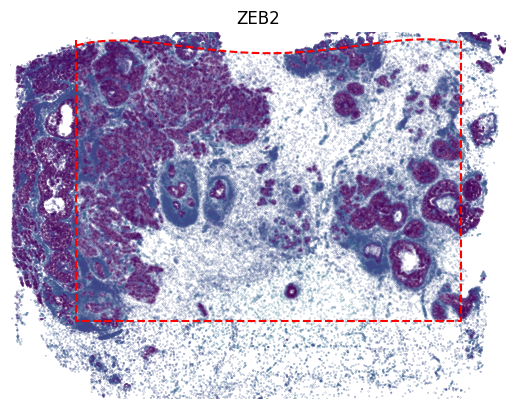

In [41]:
gene_name = 'ZEB2'
gene_idx = np.where(adata2.var_names == gene_name)[0]
vmin, vmax = adata2[:, gene_name].X.min(), adata2[:, gene_name].X.max()

value = panelB1[:, gene_idx]
x, y = adata1.obsm['image_coor'][:, 0], adata1.obsm['image_coor'][:, 1]
plt.scatter(x, y, c=value, vmin=0, vmax=vmax, s=0.01)  

value = panelB1_out[:, gene_idx]
x, y = out_spatial1['image_col'], out_spatial1['image_row']
plt.scatter(x[selection], y[selection], c=value[selection], vmin=0, vmax=vmax, s=0.02)

plt.plot(np.arange(innerx.min(), innerx.max()), boundary_func(np.arange(innerx.min(), innerx.max())), color='red', linestyle='--')
plt.plot([innerx.min(), innerx.min(), innerx.max(), innerx.max()], [innery.max(), innery.min(), innery.min(), innery.max()], 
         color='red', linestyle='--')

plt.title(gene_name)
plt.xlim((x.min(),x.max()))
plt.ylim((y.min(),y.max()))
plt.axis('off')
ax = plt.gca()
ax.set_aspect(1)
plt.show()

#### 3.2.2 Visualize the predicted Panel A on Slice 2

In [42]:
col_min, col_max = adata2.obsm['image_coor'][:, 1].min(), adata2.obsm['image_coor'][:, 1].max()
row_min, row_max = adata2.obsm['image_coor'][:, 0].min(), adata2.obsm['image_coor'][:, 0].max()
selection = (out_spatial2['image_row'] > row_min) & (out_spatial2['image_row'] < row_max) & (out_spatial2['image_col'] > col_min) & (out_spatial2['image_col'] < col_max)
obs_inner = out_spatial2[selection]
var_names = adata1.var_names

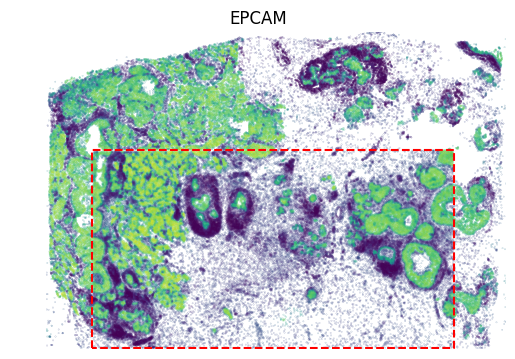

In [43]:
gene_name = 'EPCAM'
gene_idx = np.where(adata1.var_names == gene_name)[0]

value = panelA2[:, gene_idx]
vmax = value.max()
x, y = adata2.obsm['image_coor'][:, 0], adata2.obsm['image_coor'][:, 1]
plt.scatter(x, y, c=value, vmax=vmax, s=0.01)  

x = [row_min, row_min, row_max, row_max, row_min]
y = [col_min, col_max, col_max, col_min, col_min]
plt.plot(x, y, color='red', linestyle='--')

value = panelA2_out[:, gene_idx]
x, y = out_spatial2['image_col'], out_spatial2['image_row']
plt.scatter(y[~selection], x[~selection], c=value[~selection], s=0.01, vmin=0)

plt.title(gene_name)
plt.ylim((0,x.max()))
plt.xlim((0,y.max()))
plt.axis('off')
ax = plt.gca()
ax.set_aspect(1)
plt.show()